In [1]:
import pandas as pd
from scipy.stats import wilcoxon
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load ranked analysis with domains

ranked_df = pd.read_csv('./results/ranked_analysis_with_domains.csv', sep=',')
ranked_df

,result id,original,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,search term,domain
0,S-EPMC6040727,1.5,1.333333,1.333333,1.2,0.000000,0.000000,1.333333,1.333333,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,AIDS,immunology
1,Mendeley_pzp26k9fy7,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.400000,1.400000,0.000000,0.0,0.0,0.000000,0.000000,AIDS,immunology
2,DRYAD_doi.org:10.5061:dryad.9r35r,0.0,0.000000,3.666667,11.0,22.000000,11.000000,0.000000,7.333333,22.0,22.000000,22.000000,2.444444,11.0,22.0,22.000000,22.000000,AIDS,immunology
3,veupathdb_DS_e8c4cf2187,0.0,0.000000,0.000000,0.0,2.200000,3.666667,0.000000,0.000000,0.0,1.833333,3.666667,0.000000,0.0,0.0,0.000000,1.100000,AIDS,immunology
4,Dataverse_10.5064_F6SF2T3N,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.857143,2.166667,0.000000,0.0,0.0,2.600000,4.333333,AIDS,immunology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,ZENODO_5044544,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.300000,1.625000,zika microcephaly,infectious disease
477,ZENODO_5008681,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.700000,zika microcephaly,infectious disease
478,S-EPMC6256666,1.7,1.700000,0.000000,0.0,0.000000,0.000000,1.700000,0.000000,0.0,0.000000,0.000000,1.700000,0.0,0.0,0.000000,0.000000,zika microcephaly,infectious disease
479,IMMPORT_SDY1515_2,0.0,0.000000,0.000000,0.0,6.333333,9.500000,0.000000,0.000000,0.0,3.800000,9.500000,0.000000,0.0,0.0,2.375000,3.800000,sublingual immunotherapy,allergy


In [3]:
combination_order = ['original', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6',
                     'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13',
                     'c14', 'c15']

In [4]:
def compute_scores(df, combination_order):
    final_df = pd.DataFrame()

    for combi in combination_order:
        df_comb = df[['search term', combi]].copy()
        df_comb_sum = df_comb.groupby('search term').sum().reset_index()
        if final_df.empty:
            final_df = df_comb_sum
        else: 
            final_df = final_df.merge(df_comb_sum, on = 'search term')

    final_df.columns = ['search term'] + combination_order
    return final_df

In [5]:
def perform_wilcoxon_test(data):
    data = data.drop('search term', axis = 1)
    # Get the column names
    columns = data.columns
    
    # Initialize a list to hold the results
    results = []
    
    # Perform the Wilcoxon signed-rank test for each pair of columns
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            col1 = columns[i]
            col2 = columns[j]
            stat, p = wilcoxon(data[col1], data[col2])
            results.append((col1, col2, stat, p))
            
    # Create a DataFrame from the results
    results_df = pd.DataFrame(results, columns=['set 1', 'set 2', 'statistic', 'p-value'])
    return results_df

In [6]:
def compare_scores(scores, columns):
    score_comparisons = {}
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            set1 = columns[i]
            set2 = columns[j]
            if scores[set1] > scores[set2]:
                score_comparisons[(set1, set2)] = set1
            else:
                score_comparisons[(set1, set2)] = set2
    return score_comparisons

In [7]:
def add_winner(row):
    set1, set2 = row['set 1'], row['set 2']
    return winners[(set1, set2)]

In [8]:
def swap_sets(row):
    s1_index = combination_order.index(row['set 1'])
    s2_index = combination_order.index(row['set 2'])
    if s2_index < s1_index:
        return pd.Series([row['set 1'], row['set 2'], row['p-value']])  
    else:
        return pd.Series([row['set 2'], row['set 1'], row['p-value']])

In [9]:
def create_heatmap_with_winners(df, title, filename):
    heatmap_data = df.pivot('set 1', 'set 2', 'p-value')

    # Reorder index and columns
    heatmap_data = heatmap_data.reindex(combination_order, axis = 0)
    heatmap_data = heatmap_data.reindex(combination_order, axis = 1)

    # Combine winner and p-value in the annotation
    formatted_text = np.empty(heatmap_data.shape, dtype = object)
    
    for i in range(len(combination_order)):
        for j in range(len(combination_order)):
            if not np.isnan(heatmap_data.iloc[i, j]):
                formatted_text[i, j] = "{}\n{:.3f}".format(df[(df['set 1'] == combination_order[i]) & (df['set 2'] == combination_order[j])]['winner'].values[0], df[(df['set 1'] == combination_order[i]) & (df['set 2'] == combination_order[j])]['p-value'].values[0])
        else:
            formatted_text[i, j] = ""

    # Create heatmap using seaborn
    sns.set(font_scale = 1.4)
    sns.set_style('white')
    plt.figure(figsize = (24, 12))
    sns.heatmap(heatmap_data, cmap='BuPu_r', annot=formatted_text, fmt="", cbar_kws={'label': 'p-values'})
    plt.savefig(f'../alternate_test/results/{filename}.png', dpi = 150, bbox_inches = 'tight')
    plt.show()

In [10]:
allergy_ranked_df = ranked_df.loc[ranked_df['domain'] == 'allergy']
allergy_ranked_df

,result id,original,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,search term,domain
39,S-EPMC4880857,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,allergen skin prick test,allergy
40,ZENODO_4967664,3.000000,3.000000,3.000000,3.000000,5.000000,3.000000,3.000000,3.000000,3.000000,7.500000,5.000000,3.000000,3.000000,7.500000,7.500000,5.000000,allergen skin prick test,allergy
41,S-EPMC2582048,3.000000,3.000000,3.000000,6.000000,6.000000,3.000000,3.000000,3.000000,6.000000,4.000000,3.000000,3.000000,3.000000,2.400000,3.000000,3.000000,allergen skin prick test,allergy
42,IMMPORT_SDY545,0.000000,0.000000,0.000000,0.000000,0.000000,4.666667,0.000000,0.000000,0.000000,0.000000,2.800000,0.000000,0.000000,0.000000,0.000000,2.800000,allergen skin prick test,allergy
43,S-EPMC3574828,8.000000,8.000000,8.000000,5.333333,2.666667,1.600000,8.000000,8.000000,5.333333,3.200000,1.777778,8.000000,8.000000,5.333333,3.200000,2.666667,allergen skin prick test,allergy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,S-EPMC5479315,20.000000,20.000000,20.000000,20.000000,10.000000,3.333333,20.000000,20.000000,20.000000,6.666667,2.500000,20.000000,20.000000,20.000000,6.666667,3.333333,sublingual immunotherapy,allergy
415,S-EPMC6166283,3.166667,3.800000,3.166667,2.714286,1.900000,0.000000,3.166667,3.166667,2.714286,1.900000,0.000000,3.166667,3.166667,2.111111,1.900000,0.000000,sublingual immunotherapy,allergy
416,VIVLI_4561de30-5510-4875-9ef6-1327d249bf57,2.333333,2.333333,5.250000,5.250000,5.250000,5.250000,2.625000,5.250000,5.250000,10.500000,7.000000,3.000000,5.250000,10.500000,21.000000,21.000000,sublingual immunotherapy,allergy
417,VIVLI_c9c0ceae-a4b7-4f7f-af04-80bffe832169,0.000000,0.000000,0.000000,2.333333,2.625000,3.000000,0.000000,2.333333,3.500000,3.500000,5.250000,2.100000,3.000000,4.200000,10.500000,10.500000,sublingual immunotherapy,allergy


In [11]:
# Calculate scores per search term per combination

allergy_scores_df = compute_scores(allergy_ranked_df, combination_order)
allergy_scores_df

,search term,original,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15
0,allergen skin prick test,41.686111,41.722222,41.722222,40.866667,40.844444,41.322222,41.722222,41.722222,40.852778,41.296825,41.144444,41.700000,41.722222,41.746825,41.546825,41.122222
1,allergy treatment,36.311111,42.254762,43.904762,45.829762,46.657540,46.603968,42.726984,43.004762,45.592857,47.437302,47.443651,42.277778,42.966667,45.031746,47.750794,48.427778
2,asthma,45.394048,48.527381,49.685317,49.715079,49.984921,50.785317,48.527381,49.285317,49.715079,50.429365,51.115079,48.323810,48.618651,49.066270,49.737698,50.932540
3,sublingual immunotherapy,59.171429,59.171429,59.660317,59.280952,54.619444,54.033333,59.157540,59.771429,59.075397,55.144444,54.032540,59.511111,59.777778,58.521825,58.530556,57.582540


In [12]:
# Run Wilcoxon test

allergy_wilcoxon_df = perform_wilcoxon_test(allergy_scores_df)
allergy_wilcoxon_df

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,set 1,set 2,statistic,p-value
0,original,c1,1.0,0.250
1,original,c2,0.0,0.125
2,original,c3,2.0,0.375
3,original,c4,3.0,0.625
4,original,c5,3.0,0.625
...,...,...,...,...
115,c12,c14,4.0,0.875
116,c12,c15,3.0,0.625
117,c13,c14,2.0,0.375
118,c13,c15,3.0,0.625


In [13]:
# Export scores per search term

allergy_scores_df.to_csv('../alternate_test/results/scores_allergy.csv', index = False)

In [14]:
# Drop search term column

allergy_scores_only_df = allergy_scores_df.drop(columns = ['search term'])
allergy_scores_only_df

,original,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15
0,41.686111,41.722222,41.722222,40.866667,40.844444,41.322222,41.722222,41.722222,40.852778,41.296825,41.144444,41.700000,41.722222,41.746825,41.546825,41.122222
1,36.311111,42.254762,43.904762,45.829762,46.657540,46.603968,42.726984,43.004762,45.592857,47.437302,47.443651,42.277778,42.966667,45.031746,47.750794,48.427778
2,45.394048,48.527381,49.685317,49.715079,49.984921,50.785317,48.527381,49.285317,49.715079,50.429365,51.115079,48.323810,48.618651,49.066270,49.737698,50.932540
3,59.171429,59.171429,59.660317,59.280952,54.619444,54.033333,59.157540,59.771429,59.075397,55.144444,54.032540,59.511111,59.777778,58.521825,58.530556,57.582540


In [15]:
# Compute total scores per combination

allergy_total_scores_df = allergy_scores_only_df.sum()
allergy_total_scores_df

original    182.562698
c1          191.675794
c2          194.972619
c3          195.692460
c4          192.106349
c5          192.744841
c6          192.134127
c7          193.783730
c8          195.236111
c9          194.307937
c10         193.735714
c11         191.812698
c12         193.085317
c13         194.366667
c14         197.565873
c15         198.065079
dtype: float64

In [16]:
# Determine winners by comparing combination scores

winners = compare_scores(allergy_total_scores_df, combination_order)
winners

{('original', 'c1'): 'c1',
 ('original', 'c2'): 'c2',
 ('original', 'c3'): 'c3',
 ('original', 'c4'): 'c4',
 ('original', 'c5'): 'c5',
 ('original', 'c6'): 'c6',
 ('original', 'c7'): 'c7',
 ('original', 'c8'): 'c8',
 ('original', 'c9'): 'c9',
 ('original', 'c10'): 'c10',
 ('original', 'c11'): 'c11',
 ('original', 'c12'): 'c12',
 ('original', 'c13'): 'c13',
 ('original', 'c14'): 'c14',
 ('original', 'c15'): 'c15',
 ('c1', 'c2'): 'c2',
 ('c1', 'c3'): 'c3',
 ('c1', 'c4'): 'c4',
 ('c1', 'c5'): 'c5',
 ('c1', 'c6'): 'c6',
 ('c1', 'c7'): 'c7',
 ('c1', 'c8'): 'c8',
 ('c1', 'c9'): 'c9',
 ('c1', 'c10'): 'c10',
 ('c1', 'c11'): 'c11',
 ('c1', 'c12'): 'c12',
 ('c1', 'c13'): 'c13',
 ('c1', 'c14'): 'c14',
 ('c1', 'c15'): 'c15',
 ('c2', 'c3'): 'c3',
 ('c2', 'c4'): 'c2',
 ('c2', 'c5'): 'c2',
 ('c2', 'c6'): 'c2',
 ('c2', 'c7'): 'c2',
 ('c2', 'c8'): 'c8',
 ('c2', 'c9'): 'c2',
 ('c2', 'c10'): 'c2',
 ('c2', 'c11'): 'c2',
 ('c2', 'c12'): 'c2',
 ('c2', 'c13'): 'c2',
 ('c2', 'c14'): 'c14',
 ('c2', 'c15'): 'c1

In [17]:
# Add winners to Wilcoxon test results

allergy_wilcoxon_df['winner'] = allergy_wilcoxon_df.apply(add_winner, axis = 1)
allergy_wilcoxon_df

,set 1,set 2,statistic,p-value,winner
0,original,c1,1.0,0.250,c1
1,original,c2,0.0,0.125,c2
2,original,c3,2.0,0.375,c3
3,original,c4,3.0,0.625,c4
4,original,c5,3.0,0.625,c5
...,...,...,...,...,...
115,c12,c14,4.0,0.875,c14
116,c12,c15,3.0,0.625,c15
117,c13,c14,2.0,0.375,c14
118,c13,c15,3.0,0.625,c15


In [18]:
allergy_wilcoxon_df['winner'].value_counts()

c15    15
c14    14
c3     13
c8     12
c2     11
c13    10
c9      9
c7      8
c10     7
c12     6
c5      5
c6      4
c4      3
c11     2
c1      1
Name: winner, dtype: int64

In [19]:
allergy_wilcoxon_df[allergy_wilcoxon_df['p-value'] <= 0.05]

,set 1,set 2,statistic,p-value,winner


In [20]:
# Export Wilcoxon test results

allergy_wilcoxon_df.to_csv('../alternate_test/results/wilcoxon_with_winners_allergy.csv', index = False)

In [21]:
# Rearrange rows so that heatmap cells are rendered below the main diagonal

allergy_wilcoxon_df[['set 1', 'set 2', 'p-value']] = allergy_wilcoxon_df.apply(swap_sets, axis = 1)

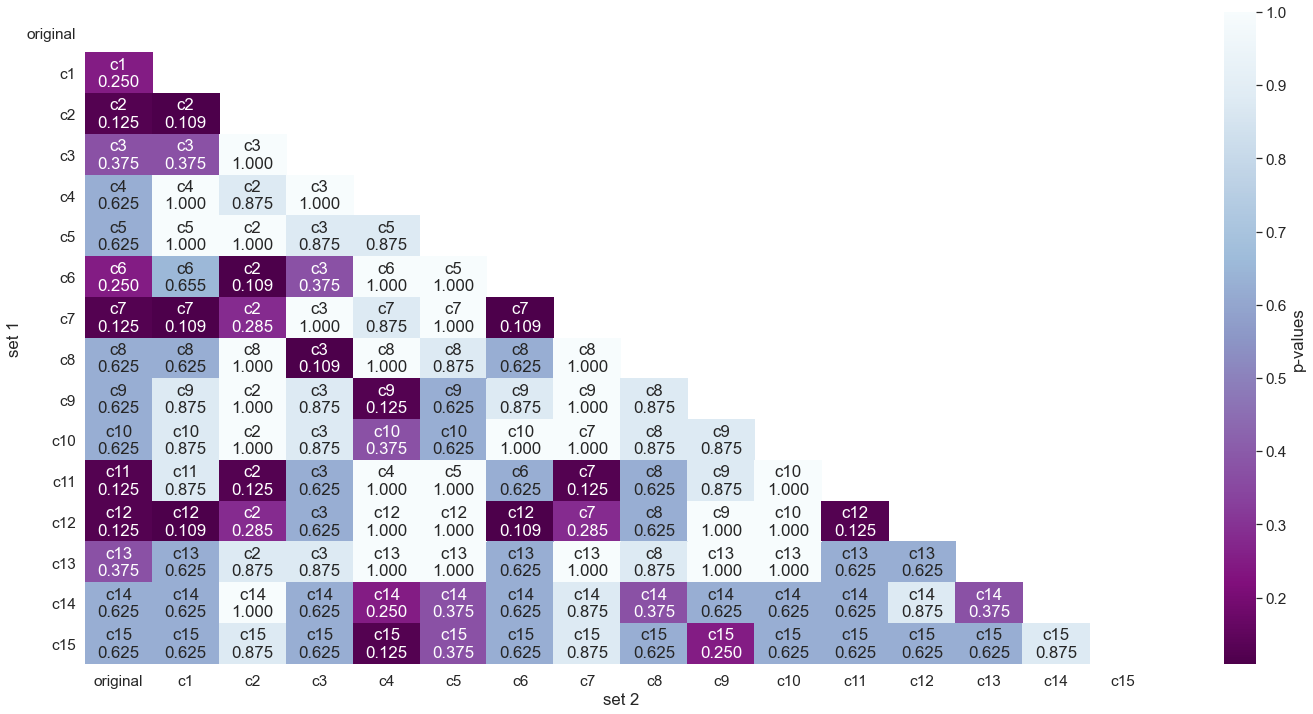

In [22]:
# Generate heatmap of p-values with winners

create_heatmap_with_winners(allergy_wilcoxon_df, 'Heatmap of p-values | Wilcoxon test', 
                            'wilcoxon_heatmap_with_winners_allergy')